# Homewok 5: LeNet5--Forward Propagation

Welcome to the course **AI and Deep learning**! In this homework, we are going to consider the forward propagation for the landmark CNN, LeNet5. The task for this neural network is to identify the handwritten digits from a 32x32 gray-scale images. The details about this architecture are shown below. 


**Learning Goal**: In this homework, we mainly implement convolution, pooling and fully connected layers.  After this homework, you will know:
 * How to code up a convolution layer, a pooling layer and a fully connected layer.
 * You will have a deeper understanding about commands, including np.sum and np.max.
 


## Table of content
* [1 - Packages](#1)
* [2 - Forward Propagation for LeNet5](#2)
  * [2.1 - Generate a training dataset](#2.1)
  * [2.2 - Activation functions](#2.2)
  * [2.3 - Building blocks](#2.3)
  * [2.4 - Integration](#2.4)




<a name='1'></a>
## 1- Packages

In order to finish a task, we need commands from certain **Python** packages. We need a package **torchvision** to download the handwritten dataset.

In [2]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
import numpy as np
# import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plots

The next command is used to download the handwritten dataset, including a training dataset and a test dataset. Both datasets contains images and the associated labels. In this homework, we do not touch test dataset, but it is provided for the sake of completion. 

In [3]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

In this homework, we only use commands from **numpy** to code up the forward propagation. Thus, we need to obtain np.arrays. Due to the limitation of memory, we may only consider the first 1000 images and labels. The size for the downloaded data is 28x28, but we need 32x32 for analysis. There are several ways to rescale a 28x28 images to 32x32, and we consider padding for simplicity in this homework.

In [4]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
train_image = np.pad(np.array(trainset.data),((0,0),(2,2),(2,2)),'constant')[0:1000] # Originally, it is 28 X 28. We need to pad two 0's on all sides to get a 32 X 32 image
train_label =np.array(trainset.targets)[0:1000]

# The following two lines convert the numeric labels to one-hot representatoin
temp = np.eye(10)  
train_label_one_hot = temp[train_label,]

For illustration purpose, consider the 11th image and its labels. First, we check the numeric label with its one-hot representation.

In [5]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
i=10
print(train_label[i])
print(train_label_one_hot[i])

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Check whether the image size is 32x32

In [6]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
train_image[i].shape

(32, 32)

Check the 11th image as well as its label.

3

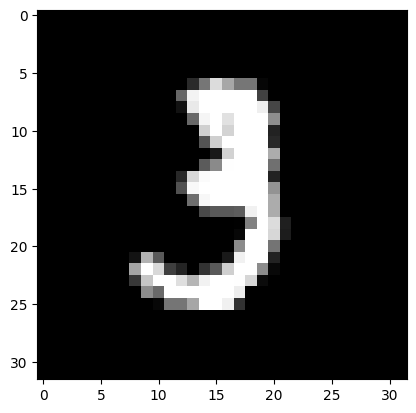

In [7]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
plt.imshow(train_image[i], cmap='gray')
train_label[i]

<a name='2'></a>
## 2 - Forward Propagation for LeNet5

<a name='2.1'></a>
### 2.1 - Model structure of LeNet5

As we have discussed in class, there are five layers with model parameters for LeNet5. The inpute is a 32x32 gray-scale image, and the output is a 10-dimensional probability, since we are dealing with a classification problem with 10 potential classes. The following figure shows the basic structure of LeNet5.

LeNet5 consists of the following layers:
  * Convolution layer, including 6 kernels, each of size 5x5. Padding is 0 and stride is 1.
  * Pooling layer with padding 2 and stride 2.
  * Convolution layer, including 16 kernels, each of 5x5x6. Padding is 0 and stride is 1.
  * Pooling layer with padding 2 and stride 2.
  * Convolution layer, including 120 kernels, each of 5x5x16. Padding is 0 and stride is 1.
  * Fully connected layer, including 84 neurons. 
  * Fully connected layer, including 10 neurons. 
  
 The activation function for each hidden layer is tanh, and it is **softmax** for the output layer.

<a name='2.2'></a>
### 2.2 - Activation functions

We need the following activation functions:
  * sigmoid activation function, $\sigma(z)=(1+\exp(-z))^{-1}$ with $\sigma'(z)=\sigma(z)\{1-\sigma(z)\}$,
  * tanh activation function, $\sigma(z)=2(1+\exp(-2z))^{-1}-1$ with $\sigma'(z)=1-\sigma^2(z)$,
  * softmax activation function.

In [9]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
def sigmoid(z):
    # x: input
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [10]:
# PLEASE FINISH THE BLANK PART WITH OTHERS UNCHANGED
def tanh(z):
    # x: input
    
    ### YOUR CODE BEGINS HERE (approximately 1 line)
    sig = 2/(1 + np.exp(-2*z))-1 # Check the formula and details in the sigmoid function.
    ### YOUR CODE ENDS

    return sig

Different from the above two activation function, the following one takes a two-dimensional matrix $Z$ as an input. It first take exponenntial of each element in $Z$, and normalize each row of the resulting matrix.

In [11]:
def softmax(Z):
    # We first use exponential function for each element in Z, and normlize each row. 
    # Z: of size n x d, where n is the sample size and d is the number of feauture.
    
    ### YOUR CODE BEGINS HERE (approximately 1 line)
    A = np.exp(Z)
    sum_A = np.sum(A,axis= 1, keepdims=True)
    A /= sum_A
    ### YOUR CODE ENDS

    
    return A

<a name='2.3'></a>
### 2.3 - Building blocks

The following code is useful to briefly understand the `dictionary` structure. **The following commands are EXTREMELY important, although it is not so complex.**

In [12]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
dic = {'W[0]': 0 , 'W[1]':1} # Construct a dictionary

In [13]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
i=0
dic['W['+str(i)+']'] #use variables to extract the values for `W[0]`

0

You may need the following one in this homework

In [14]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
dic={} # declare an empty dictionary
dic['W']=0 # add a new key and value pair to the dictionary
dic['W'] # print the value for the key 'W'

0

First, we need to initilize the two dictionaries. We implement the following strategies for initialization. 
   * Initialize the weights by a random vector, whose elements are independently generated from a normal distribution with mean zero and standard deviation one, then divided by the square root of number of elements. Please use a random seed to keep the code reproducible.
   * Initialize the bias by zero.


The following command may be useful:
  * `np.random.normal`: check the help for details.
  * `np.zeros`: check the help for details.

For example, if we would like to initialize kernels for the first hidden layer, it would be `np.random.normal(0,1,5*5*6).reshape((5,5,6))/sqrt(5*5*6)`, where the first two coordinates are the kernel size and the last one is the number of kernels in this layer. Notice that there are several ways to initialize the kernels and weights randomly, but we just use standard normal distribution scaled by the square root of number of parameters.

**Important note**
  * Since the input size is 1000x5x5, the dimension of kernel for the first layer is 5x5x6. 
  * Since the input size is 1000x28x28x6 for the second layer, the kernel for this layer should be 5x5x6x16.
  * Always initialize the bias term for convolution layers to be three dimensional. That is, 1x1x6 for the first hidden layer, for example.

In [15]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def Initialize_pars(rn):
    # rn: random seed
    
    np.random.seed(rn)
    W = {}
    b = {}
    W["[1]"] = np.random.normal(0,1,5*5*6).reshape((5,5,6))/np.sqrt(5*5*6)
    b["[1]"] = np.zeros(6).reshape((1,1,6))
    
    ### YOUR CODE BEGINS HERE (approximately 8 lines)
    W["[2]"] = np.random.normal(0,1,5*5*6*16).reshape((5,5,6,16))/np.sqrt(5*5*6*16) # Check the example for W["[1]"] and b["[1]"]
    b["[2]"] = np.zeros(16).reshape((1,1,16))
    W["[3]"] = np.random.normal(0,1,5*5*16*120).reshape((5,5,16,120))/np.sqrt(5*5*16*120)
    b["[3]"] = np.zeros(120).reshape((1,1,120))
    W["[4]"] = np.random.normal(0,1,(84,120))/np.sqrt(84*120)
    b["[4]"] = np.zeros((84,1))
    W["[5]"] = np.random.normal(0,1,(10,84))/np.sqrt(10*84)
    b["[5]"] = np.zeros((10,1))
    ### YOUR CODE ENDS
    
    par = {
        'W': W,
        'b': b
          }
    
    return par
        

In [16]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
rn = 1234
par = Initialize_pars(rn)
print(par['W']['[2]'][0][0][0][0:3])
print('Your result should be:\n[ 0.01012748  0.01626042 -0.00967591]')

[ 0.01012748  0.01626042 -0.00967591]
Your result should be:
[ 0.01012748  0.01626042 -0.00967591]


Given the input size and kernel size, we need to calculate the output size. For example, if the input size is $(n,d_h,d_w,d_c)$ and there are $d_{c,new}$ kernels with size $f\times f$, then the output size is $(n,d_{h,new},d_{w,new},d_{c,new})$, where $d_{h,new} = \lfloor (d_h+2p-f)/s\rfloor+1$, where $p$ and $s$ are padding and stride numbers. The following function is used to obtain the output image size given the input image and kernels. To finish the following code, you may need the following command:
  * `//`: try `1//2` and `5//2` by yourself

In [17]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def conv_output_image_size(input_image_size, dc_new, f, p, s):
    # input_image_size: the tuple associated with the input image size, and it may of the form (n, dh, dw) or (n, dh, dw, dc), where 
    #                   n is the sample size, (dh, dw) is the size of each channel, and dc is the number of channels.
    # dc_new: number of kernels in this convolution layer
    # f: kernel size
    # p: padding
    # s: stride
    
    if len(input_image_size) == 3:
        n, dh, dw = input_image_size
    else:
        n, dh, dw,_ = input_image_size
        
    ### YOUR CODE BEGINS HERE (approximately 2 lines)
    dh_new = (dh +2 * p-f)//s + 1  # Check our slide
    dw_new = (dw + 2 * p-f)//s + 1 # Check our slide
    ### YOUR CODE ENDS
    
    return (n, dh_new, dw_new, dc_new)

In [18]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
input_image_size = (100,28,28,6)
dc_new = 16
f = 5
p=0
s=1
output_size = conv_output_image_size(input_image_size, 16, 5, 0, 1)
print(output_size)
print('Your result should be:\n(100, 24, 24, 16)')

(100, 24, 24, 16)
Your result should be:
(100, 24, 24, 16)


Next, we code up the convolution layer, and it is one of the important building blocks for CNN. We have demonstrated the details for this layer in class; check the slides for details. The following commands are useful:
  * `np.pad`: This is used for padding. If the dimension of X is (n,dh,dw,dc), then try to use `np.pad(X,((0,0),(p,p),(p,p),(0,0)),'constant')` to pad only the matrix in **EACH CHANNEL**.

In [19]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def conv_layer(input_image, kernel,b,p=0,s=1):
    # input_image: np array of the size (n, dh, dw, dc), where n is the sample size, dh, dw and dc are the three dimensions of input images.
    #              If the size is (n,dh,dw), then dc=1.
    # kernel: np array of the form (k_dh, k_dw, k_dc, k_dc_new), where (k_dh, k_dw, k_dc) is the kernel size, and k_dc_new is the number of kernels.
    # p: padding
    # s: stride
    
    ### YOUR CODE BEGINS HERE (approximately 25 lines)
    if len(input_image.shape) == 3: # Since our input is gray-scale, there is only one channel for each image. Thus, we omit that channel
        input_image = np.pad(input_image,((0,0),(p,p),(p,p)),'constant') # pad the input image
    else:
        input_image = np.pad(input_image,((0,0),(p,p),(p,p),(0,0)),'constant') # padding the input image. Different from above, we have 4 channels here
    
    input_image_size = input_image.shape # Obtain the input size
    kernel_size = kernel.shape # Obtain the kernel size
    
    output_size = conv_output_image_size(input_image_size, kernel_size[len(kernel_size)-1], kernel_size[0],p=p,s=s) # Use function conv_output_image_size to get the output image size
    output_image = np.zeros(output_size) # Initialize the output image by a tensor with elements beging zero.
    
    # Loop for each element in the output image
    for h_index in range(output_size[1]): # height index
        for w_index in range(output_size[2]): # width index
            # We need to get the starting and ending index associated with the (h_index, w_index) elements in different channels of the output image
            h_range_start = h_index*s # starting height index 
            h_range_end = h_index*s+kernel_size[0]  # ending height index
            w_range_start = w_index*s  # starting width index
            w_range_end = w_index*s+kernel_size[0]  # ending width index
            
            input_image_hwc = input_image[:,h_range_start:h_range_end,w_range_start:w_range_end] # Associated part of the input image to get the (h_index, w_index) elements in different channels of the output image
            for c_index in range(output_size[3]): # kernel index. Notice that there are output_size[3] kernels in this layer
                if len(input_image_size) == 3: # Since the input size may be three or four dimensional tensor, we consider them individually.
                    kernel_c = kernel[:,:,c_index].reshape(1,kernel_size[0],kernel_size[1]) # Extract the c_indexth kernel
                    output_image[:,h_index,w_index,c_index] = np.sum(input_image_hwc * kernel_c,axis=(1,2)) + b[0,0,c_index] # Obtain the (h_index, w_index,c_index) elements of the output image for each training example 
                else: # Same operation but for four dimensional tensors
                    kernel_c = kernel[:,:,:,c_index].reshape(1,kernel_size[0],kernel_size[1],input_image_size[3])
                    output_image[:,h_index,w_index,c_index] = np.sum(input_image_hwc * kernel_c,axis=(1,2,3))+ b[0,0,c_index]

    output_image = tanh(output_image)  # Use tanh as the activation function.
    ### YOUR CODE ENDS

    return output_image
        

In [20]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
np.random.seed(123)
input_image = np.random.normal(0,1,200).reshape(2,5,5,4)
kernel = np.random.normal(0,1,3*3*4*5).reshape(3,3,4,5)/np.sqrt(3*3*4*5)
b = np.random.normal(0,1,5).reshape(1,1,5)
p = 0
s = 1
output_image = conv_layer(input_image, kernel,b,p=0,s=1)
print(output_image[0,1,1,1])
print('Your result should be:\n-0.9771451425762684')

-0.9771451425762684
Your result should be:
-0.9771451425762684


Next, we consider a pooling layer. Remember that there are no model parameters involved in this layer, and pooling is conducted for each channel. In other words, number of channels does not change after a pooling layer. The following code is useful for max pooling:
  * `np.max`. If the dimension of X is (n,dh,dw,dc), then try to use `np.max(X,axis=(1,2))` to compute the maximum number for **EACH CHANNEL**.
  * `np.zeros_like(A)`: Generate a tensor of elements being zero, and the result has the same dimension as A.

In [21]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def pooling(input_image, p=0, f=2, s=2, tag = "average"):
    # input_image: np array of the size (n, dh, dw, dc), where n is the sample size, dh, dw and dc are the three dimensions of input images.
    # kernel: np array of the form (k_dh, k_dw, k_dc, k_dc_new), where (k_dh, k_dw, k_dc) is the kernel size, and k_dc_new is the number of kernels.
    # p: padding
    # f: kernel size 
    # s: stride
    # tag: whether "average" or "max" corresponding to "average pooling" or "max pooling"
    
    ### YOUR CODE BEGINS HERE (approximately 20 lines)
    input_image_size = input_image.shape  # Obtain the size of the input image
    output_size = conv_output_image_size(input_image_size, input_image_size[3], f=2, p=p,s=s)  # Use function conv_output_image_size to obtain the output image size
    output_image = np.zeros(output_size)  # Initialize the output image by a tensor with elements beging zero.
     
    ## Notice that we also need a mask matrix for pooling layer, and the mask matrix is of the same dimension as the input image
    if tag.lower() == "max":
        mask_mat = np.zeros_like(input_image) # use np.zeros_like to generate a tensor of the same size as input image
    else:
        mask_mat = np.zeros_like(input_image)+1/f/s  # Generate a tensor of the same size as input image, but its elements are 1/f/s
    
    for h_index in range(output_size[1]):
        for w_index in range(output_size[2]):
            # We need to get the starting and ending index associated with the (h_index, w_index) elements in different channels of the output image
            h_range_start = h_index*s
            h_range_end = h_index*s+f
            w_range_start = w_index*s
            w_range_end = w_index*s+f
            input_image_hwc = input_image[:,h_range_start:h_range_end,w_range_start:w_range_end,:]
            
            # We can use the `axis` argument in np.mean or np.max to avoid a "for loop"  associated with the number of channels
            if tag.lower() == "average":
                output_image[:,h_index,w_index,:] = np.mean(input_image_hwc, axis = (1,2)) 
            else:
                hw_max = np.max(input_image_hwc, axis = (1,2),keepdims=True)
                mask_mat[:,h_range_start:h_range_end,w_range_start:w_range_end,:] = input_image[:,h_range_start:h_range_end,w_range_start:w_range_end,:] == hw_max
                output_image[:,h_index,w_index,:] = hw_max.reshape(input_image_size[0],input_image_size[3])
    ### YOUR CODE ENDS
        
    return(output_image, mask_mat)
            

In [22]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
np.random.seed(123)
input_image = np.random.normal(0,1,160).reshape(2,4,4,5)
p = 0
f = 2
s = 2
print("*"*8+'  Average pooling')
output_image, mask_mat = pooling(input_image, 0,2,2,"average")
print(output_image[0,1,1,1])
print('Your result should be:\n-0.34565071031429234')
output_image, mask_mat = pooling(input_image, 0,2,2,"max")
print('*'*8+'  Max pooling')
print(output_image[0,1,1,1])
print('Your result should be:\n0.8907063912931708')

********  Average pooling
-0.34565071031429234
Your result should be:
-0.34565071031429234
********  Max pooling
0.8907063912931708
Your result should be:
0.8907063912931708


Next, we consider a fully connected layer, and we should be familar with this layer.


In [23]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def fc_layer(input_image, W,b, activation):
    # input_image: two dimensional of the form (n,num_feature), where num_feature is the number of features of the input
    # W: kernel of size (num_feature_new, num_feature), where num_feature_new is the number of features for the output.
    # b: bias tern of size (num_feature_new,1)
    # activation: activation

    ### YOUR CODE BEGINS HERE (approximately 20 lines)    
    output_image = activation(input_image @ W.transpose()+b.transpose())
    ### YOUR CODE ENDS

    return output_image

In [24]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
import numpy as np
np.random.seed(123)
input_image = np.random.normal(0,1,300).reshape(30,10)
W = np.random.normal(0,1,8*10).reshape(8,10)/np.sqrt(8*10)
b = np.random.normal(0,1,8).reshape(8,1)
output_image = fc_layer(input_image, W,b,tanh)
print(output_image[0,1])
print('Your result should be:\n-0.860663185653378')

-0.860663185653378
Your result should be:
-0.860663185653378


<a name='2.4'></a>
### 2.4 - Integration 

Finally, we code up a LeNet5 integrating those functions

In [26]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def forward(X, one_hot,par):
    # X: input image of size (n, dw, dh)
    # one_hot: one_hot representation of the labels. 
    # par: initial parameters

    n = X.shape[0] 
    W = par['W']
    b = par['b']

    ### YOUR CODE BEGINS HERE (approximately 13 lines) 
    A1 = conv_layer(input_image = X, kernel = W["[1]"], b = b["[1]"],p=0,s=1) # Results after convolution layer
    A1_p, M1 = pooling(A1, p=0, f=2, s=2) # Results after pooling layer
    A2 = conv_layer(input_image = A1_p, kernel = W["[2]"], b = b["[2]"],p=0,s=1) # Results after convolution layer
    A2_p, M2 = pooling(A2, p=0, f=2, s=2)# Results after pooling layer
    A3 = conv_layer(input_image = A2_p, kernel = W["[3]"], b = b["[3]"],p=0,s=1) # Results after convolution layer
    A3_vec = A3.reshape(n,120) # Change the four dimensional tensor to a two dimensional matrix
    A4 = fc_layer(A3_vec, W["[4]"], b["[4]"], tanh) # Results after fully connected layer layer
    A5 = fc_layer(A4, W["[5]"], b["[5]"], softmax) # Results after fully connected layer layer
    
    J = - np.sum(one_hot * np.log(A5))/n   # Cost function
    ### YOUR CODE ENDS
    
    cache = {
        'J': J,
        'A1': A1,
        'A1_p': A1_p,
        'M1': M1,
        'A2': A2,
        'A2_p': A2_p,
        'M2':M2,
        'A3':A3,
        'A3_vec': A3_vec,
        'A4':A4,
        'A5':A5
    }
    return cache
    

In [28]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
X = train_image
one_hot = train_label_one_hot
rn = 1234
par = Initialize_pars(rn)
cache = forward(X, one_hot,par)
print(cache['J'])
print('Your result should be:\n2.302640196814468')

2.302640196814468
Your result should be:
2.302640196814468


Advanced topics:
  * How about the backpropagation?